In [1]:
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-06-29 13:58:43.975897: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 13:58:43.977882: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 13:58:44.008375: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 13:58:44.009215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 13:58:44.573193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
BATCH_SIZE = 100
NUM_BITS_PER_SYMBOL = 4
CODERATE = 0.5

NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 4
NUM_STREAMS_PER_TX = NUM_UT_ANT

RX_TX_ASSOCIATION = np.array([[1]])
STREAM_MANAGEMENT = sn.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

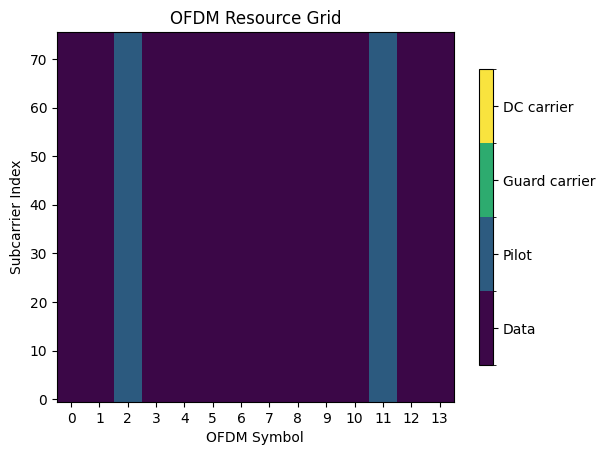

In [3]:
resource_grid = sn.ofdm.ResourceGrid(
    num_ofdm_symbols=14,
    fft_size=76,
    subcarrier_spacing=30e3,
    num_tx=NUM_UT,
    num_streams_per_tx=NUM_STREAMS_PER_TX,
    cyclic_prefix_length=6,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[2,11]
)


resource_grid.show();

In [4]:
frequencies

NameError: name 'frequencies' is not defined

In [ ]:
CARRIER_FREQUENCY = 1.9e9

ut_array = sn.channel.tr38901.Antenna(
    polarization='single',
    polarization_type='V',
    antenna_pattern='omni',
    carrier_frequency=CARRIER_FREQUENCY
)

bs_array = sn.channel.tr38901.AntennaArray(
    num_rows=1,
    num_cols=NUM_BS_ANT,
    polarization='dual',
    polarization_type='cross',
    antenna_pattern='38.901',
    carrier_frequency=CARRIER_FREQUENCY
)

In [ ]:
DELAY_SPREAD = 100e-9
DIRECTION = 'uplink'
CDL_MODEL = 'C'
SPEED = 0.0

CDL = sn.channel.tr38901.CDL(
    CDL_MODEL,
    DELAY_SPREAD,
    CARRIER_FREQUENCY,
    ut_array=ut_array,
    bs_array=bs_array,
    direction=DIRECTION,
    min_speed=SPEED
)

In [ ]:
NUM_CODED_BITS = int(resource_grid.num_data_symbols * NUM_BITS_PER_SYMBOL)
NUM_INFO_BITS = int(NUM_CODED_BITS * CODERATE)

class OFDMModel(tf.keras.Model):
    
    def __init__(self, cdl_model):
        super().__init__()

        constellation = sn.utils.Constellation('qam', NUM_BITS_PER_SYMBOL)

        self.binary_source = sn.utils.BinarySource()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=self.encoder, hard_out=True)

        self.mapper = sn.mapping.Mapper('qam', NUM_BITS_PER_SYMBOL)
        self.demapper = sn.mapping.Demapper('app', constellation=constellation)

        self.rg_mapper = sn.ofdm.ResourceGridMapper(resource_grid)

        self.ls_est = sn.ofdm.LSChannelEstimator(resource_grid=resource_grid, interpolation_type='nn')

        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(resource_grid, STREAM_MANAGEMENT)

        self.cdl = CDL = sn.channel.tr38901.CDL(
            cdl_model,
            DELAY_SPREAD,
            CARRIER_FREQUENCY,
            ut_array=ut_array,
            bs_array=bs_array,
            direction=DIRECTION,
            min_speed=SPEED
        )

        self.channel = sn.channel.OFDMChannel(
            self.cdl,
            resource_grid,
            add_awgn=True,
            normalize_channel=True,
        )

    @tf.function
    def __call__(self, batch_size, ebno_db):

        no = sn.utils.ebnodb2no(
            ebno_db,
            NUM_BITS_PER_SYMBOL,
            CODERATE,
            resource_grid
        )

        bits = self.binary_source([batch_size, NUM_UT, resource_grid.num_streams_per_tx, NUM_INFO_BITS])
        
        codewords = self.encoder(bits)
        
        qam_symbols = self.mapper(codewords)
        
        ofdm_symbols = self.rg_mapper(qam_symbols)
          
        response = self.channel([ofdm_symbols, no])

        estimation, err_var = self.ls_est([response, no])
        
        equalized_symbols, no_eff = self.lmmse_equ([response, estimation, err_var, no])

        llr = self.demapper([equalized_symbols, no_eff])
        
        bits_hat = self.decoder(llr)

        return bits, bits_hat

In [ ]:
ber_plots = sn.utils.PlotBER('OFDM')
EBNO_DBS = np.linspace(-5,10,16)

model_a = OFDMModel('A')
model_b = OFDMModel('B')
model_c = OFDMModel('C')
model_d = OFDMModel('D')
model_e = OFDMModel('E')

In [ ]:
ber_plots.simulate(
    model_a,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=1000,
    legend='Model A',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=False
);

2023-06-29 13:57:26.588616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


AttributeError: in user code:

    File "/tmp/ipykernel_80930/609714194.py", line 62, in __call__  *
        equalized_symbols, no_eff = self.lmmse_equ([response, estimation, err_var, no])

    AttributeError: 'OFDMModel' object has no attribute 'lmmse_equ'


In [ ]:
ber_plots.simulate(
    model_b,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=1000,
    legend='Model B',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=False
);

In [ ]:
ber_plots.simulate(
    model_c,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=1000,
    legend='Model C',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=False
);

In [ ]:
ber_plots.simulate(
    model_d,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=1000,
    legend='Model D',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=False
);

In [ ]:
ber_plots.simulate(
    model_e,
    batch_size=BATCH_SIZE,
    ebno_dbs=EBNO_DBS,
    num_target_bit_errors=1000,
    legend='Model E',
    soft_estimates=True,
    max_mc_iter=100,
    show_fig=False
);

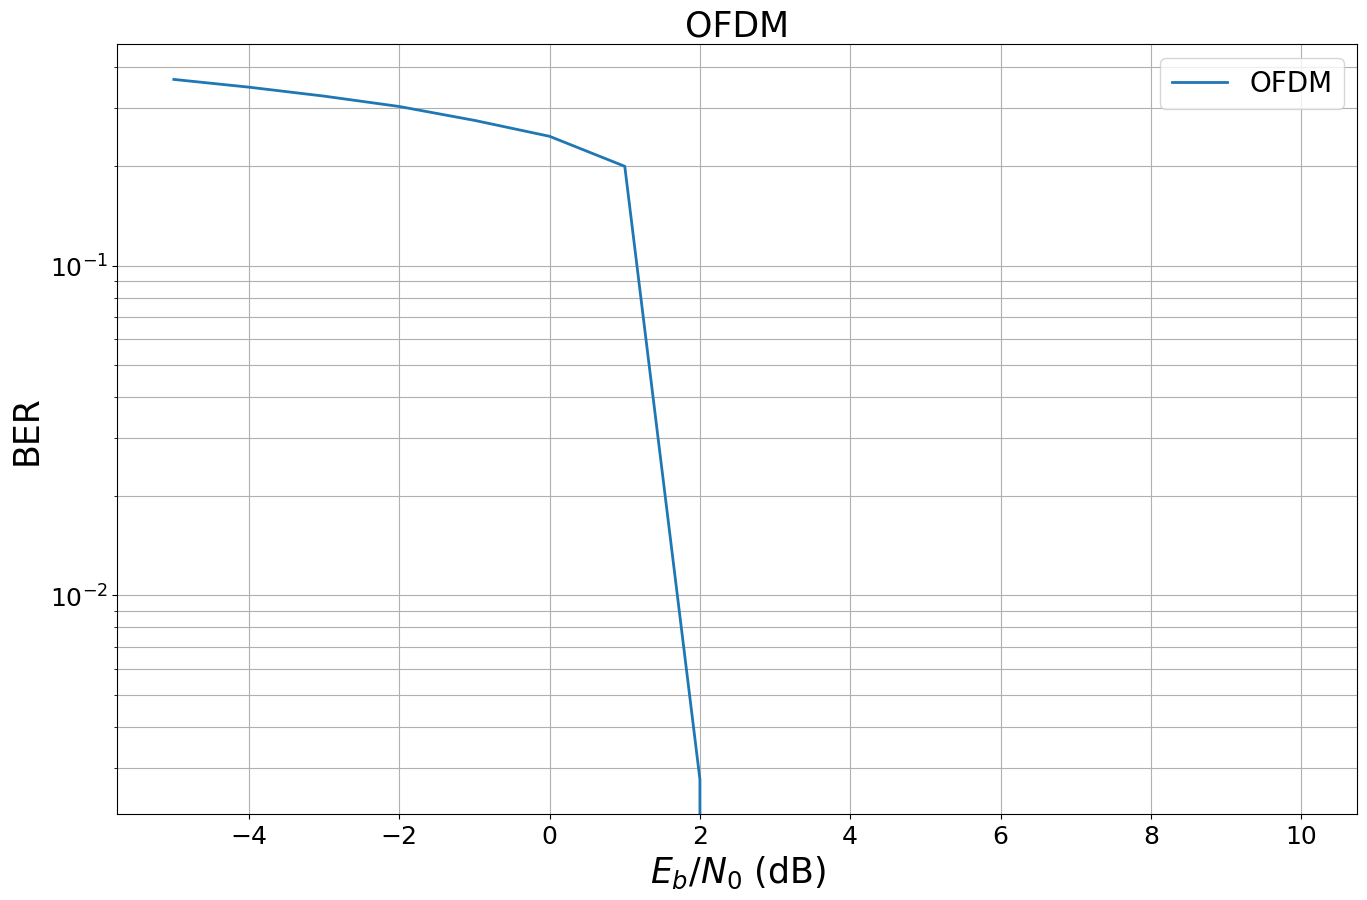

In [ ]:
ber_plots()